In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
from feature_maps import MediumFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer
from SVM import SVM
from sklearn.svm import SVC
from shot_based_kernel import BinomialKernel

In [8]:
# blue
color_0 = '#1f77b4'
color_0_light = '#8fbbd9'

# orange
color_1 = '#ff7f0e'
color_1_light = '#ffbf86'

colors = [color_0, color_1]
colors_light = [color_0_light,color_1_light]

# other constants
lower_percentile = 0.159
upper_percentile = 0.841

plt.rcParams.update({'font.size': 24,
                     'xtick.labelsize': 20,
                     'ytick.labelsize': 20,
                     'axes.titlesize': 28,
                     'axes.labelsize': 28,
                     'mathtext.fontset': 'stix',
                     'font.family': 'STIXGeneral'})

In [35]:
margin=-0.1
M = 256
sep = 'separable' if margin > 0 else 'overlap'
shots = [4,8,16,32,64,128,256,512,1024,2048,4096, 8192] #list(set(df['R'])) #
#shots = 10**np.arange(4,15,2)
shots.sort()
n_seeds = 100
rng = np.random.default_rng(42)
seeds = rng.integers(0,10000,n_seeds)
Cs = [10.,1000.]

In [30]:
backend = QuantumInstance(Aer.get_backend('statevector_simulator'))
feature_map = MediumFeatureMap(2,4)
kernel = QuantumKernel(feature_map=feature_map.get_reduced_params_circuit(), quantum_instance=backend)

In [31]:
def load_data(M, margin, seed = 42):
    assert (M <= 2048) & (M % 2 == 0)
    y = np.array(pd.read_csv(f'data/2-qubits/{margin}_y_2048.csv')).reshape(-1)
    X = np.array(pd.read_csv(f'data/2-qubits/{margin}_X_2048.csv'))

    np.random.seed(seed)
    indices1 = np.random.randint(0,np.sum(y == 1),M//2)
    indices2 = np.random.randint(0,np.sum(y == -1),M//2)

    X1 = X[y == 1][indices1]
    y1 = y[y == 1][indices1]
    X2 = X[y == -1][indices2]
    y2 = y[y == -1][indices1]

    X12 = np.vstack([X1,X2])
    y12 = np.append(y1,y2)

    shuffle = np.random.choice(M, M, replace=False)
    return X12[shuffle], y12[shuffle]

[-2.81750412  9.71568146]
[-2.20883606 21.43724697]


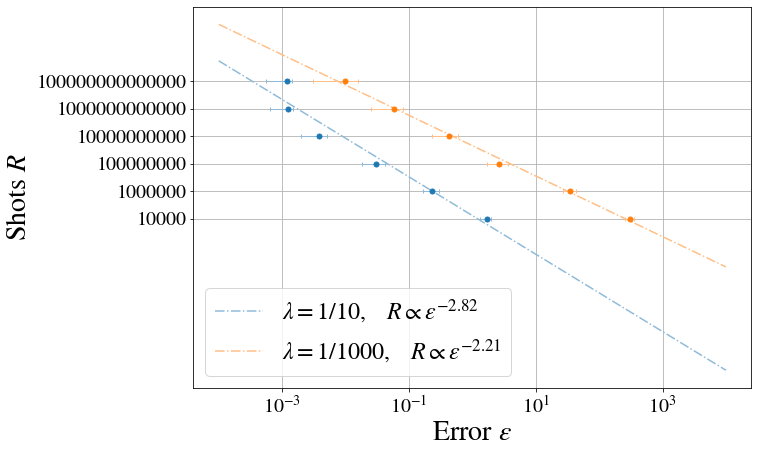

In [37]:
plt.figure(figsize=(10,7))
#epsilons = np.zeros((len(Cs), len(seeds), len(shots)))
for i, C in enumerate(Cs):
    for j, s in enumerate(seeds):
        X, y = load_data(M, margin, s)
        K = kernel.evaluate(X)
        K[K < 0 ] = 0
        K[K > 1] = 1
        svm = SVC(kernel='precomputed', C=C)
        svm.fit(K, y)
        h = svm.decision_function(K)
        
        shots_kernel = BinomialKernel(K)
        for l, R in enumerate(shots):
            K_R = shots_kernel.approximate_kernel(R, s)
            svm_R = SVC(kernel='precomputed', C=C)
            if svm_R.fit(K_R, y):
                h_R = svm_R.decision_function(K_R)
                epsilons[i, j, l] = np.max(np.abs(h - h_R))
            else:
                print(f'failed {R}')
                epsilons[i, j, l] = 100

    means = np.mean(epsilons[i,:],axis=0)
    upper = np.quantile(epsilons[i,:], upper_percentile, axis=0)
    lower = np.quantile(epsilons[i,:],lower_percentile,axis=0)
    errors = np.array([means - lower, upper - means])

    plt.errorbar(means,shots,xerr=errors,marker='.',ecolor=colors_light[i],elinewidth=1.,ls='',capsize=2,
        color=colors[i], ms=10)
    #plt.scatter(means,shots,c=colors[i])
    #plt.errorbar(means,shots,xerr=stds,fmt='.')
    plt.xscale('log')
    plt.yscale('log')
    p = np.polyfit(np.log(means),np.log(shots),1)
    print(p)
    efine = np.geomspace(0.0001,1e4,1000)
    plt.plot(efine,np.exp(p[1])*efine**(p[0]),linestyle='-.',label=r'$\lambda = 1/{{%s}},\quad R\propto\varepsilon^{{%.2f}}$'%(int(C),p[0]),color=colors_light[i])

plt.yticks(shots,shots)
#plt.xlim(1e-1,1e4)
#plt.ylim(2,1e4)
plt.xlabel(r'Error $\varepsilon$')
plt.ylabel(r'Shots $R$')
plt.grid()
plt.legend(loc='lower left')
#plt.savefig(f'plots/dual_exponent_{sep}.png',dpi=300,bbox_inches='tight')